# Unraveling Representations in Body-Selective Brain Regions with Body-aware Neural Networks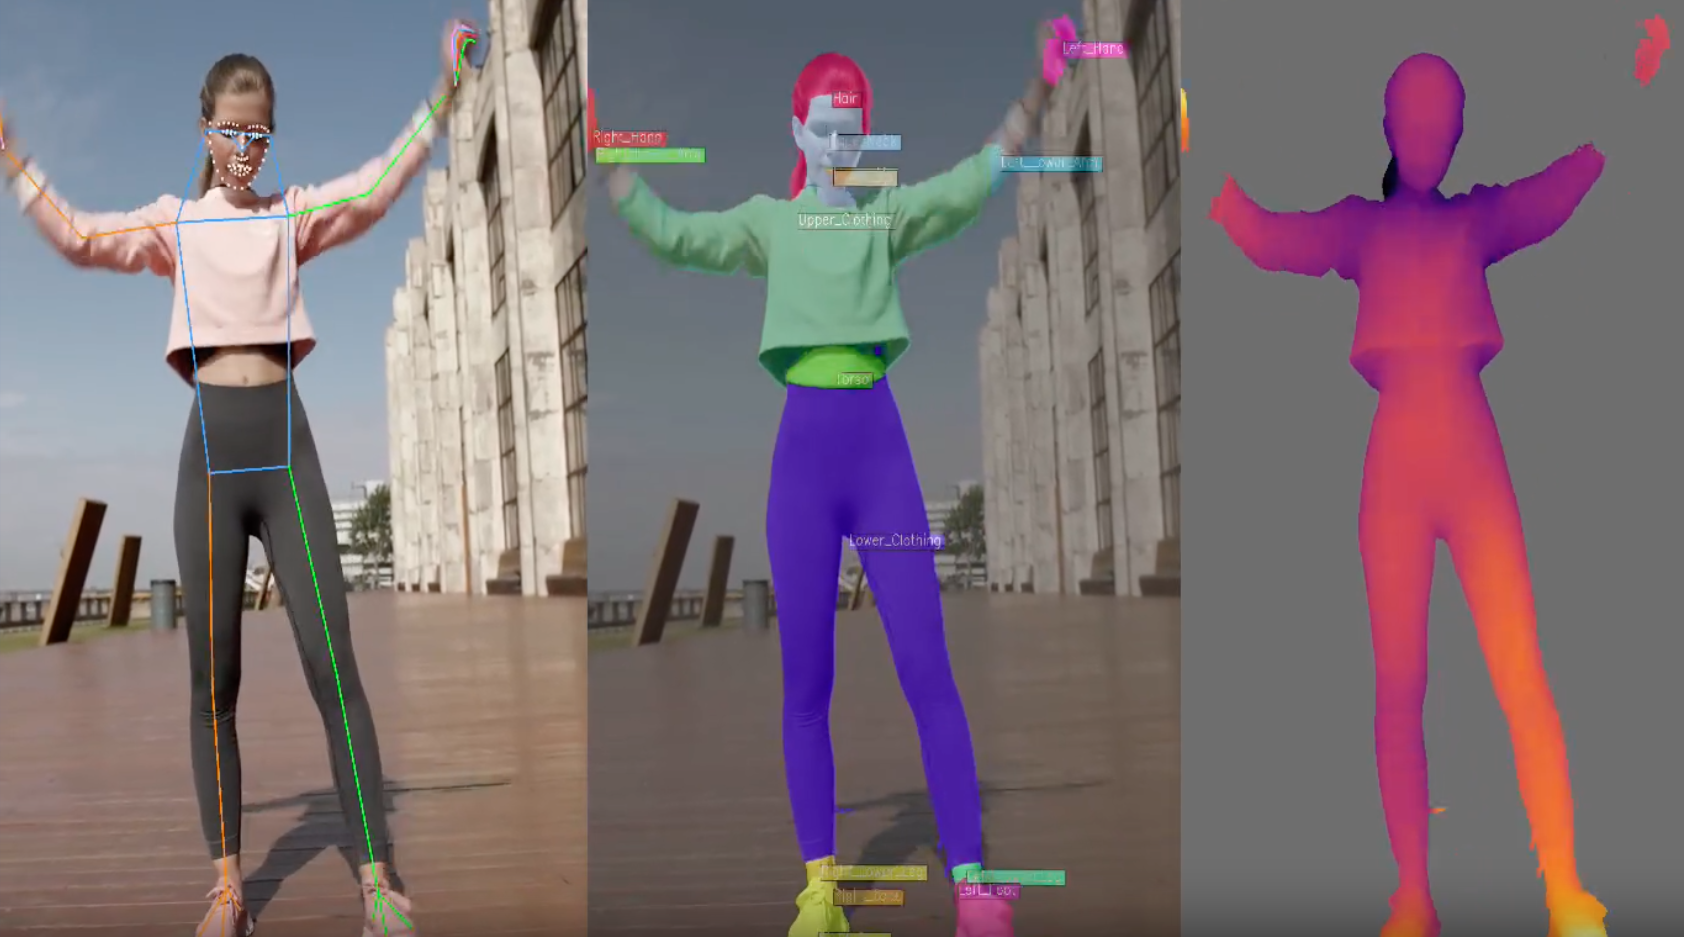

The purpose of this study is to unravel representations in body-selective brain regions (i.e., EBA and FBA) with body-parsing neural networks (i.e., pose estimation and body segmentation models). Specifically, it aims to:

1.   Perform Representational Similarity Analysis (RSA) between neural networks and body-selective brain regions.
2.   Conduct variance partitioning to determine the contributions of each neural network model to explaining the variance in the neural responses in body-selective brain regions.



# Import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
import h5py
from scipy.io import loadmat
from scipy.stats import spearmanr
import seaborn as sns
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import pairwise_distances
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import os
import torch
import cv2
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Define subjects, ROIs, networks, and image features

In [ ]:
subject_list = [1]
brain_roi_list = ['V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4', 'EBA', 'OFA', 'FFA_1']
other_roi_list = ['FFA_2', 'FBA_1', 'FBA_2']
neural_network_list = ['pose', 'seg', 'random_pose', 'random_seg']
image_feature_list = ['area', 'hmax', 'polar_angle', 'polar_distance'] # we'll control for these variables later

# Define utility classes and functions

### Create RDM Analyzer

In [ ]:
class RDMAnalyzer:
    """
    A class for Representational Dissimilarity Matrix (RDM) analysis.
    """
    def __init__(self, base_path='/content/drive/MyDrive/ML Project/'):
        """
        Initializes the RDMAnalyzer with a base path.

        :param base_path: Base directory where RDM results are stored.
        """
        self.base_path = base_path

    def load_rdm(self, subj: int, roi: str) -> tuple:
        """
        Loads RDM data for a given subject and region of interest (ROI).

        :param subj: Subject identifier.
        :param roi: Region of interest.
        :return: Tuple containing left and right hemisphere RDMs.
        """
        path = f'{self.base_path}RDM_results/subj{subj}/{roi}_rdms.npz'
        rdms = np.load(path)
        return rdms['left'], rdms['right']

    @staticmethod
    def compute_rdm(data_matrix: np.ndarray) -> np.ndarray:
        """
        Computes the RDM using correlation distance.

        :param data_matrix: Input data matrix.
        :return: Computed RDM.
        """
        return 1 - np.corrcoef(data_matrix)

    @staticmethod
    def perform_rsa(rdm1: np.ndarray, rdm2: np.ndarray) -> tuple:
        """
        Performs Representational Similarity Analysis (RSA) between two RDMs.

        :param rdm1: First RDM (flattened upper triangle).
        :param rdm2: Second RDM (flattened upper triangle).
        :return: Spearman correlation coefficient and p-value.
        """
        return spearmanr(rdm1, rdm2)

### Create RDM Preprocessor

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

class RDMPreprocessor:
    """
    A class for preprocessing Representational Dissimilarity Matrices (RDMs).
    """

    def remove_influence(rdm: np.ndarray, *feature_rdms: np.ndarray) -> np.ndarray:
        """
        Removes the influence of feature RDMs from the target RDM using linear regression.
        This is useful for partial correlation calculations.

        Parameters:
        -----------
        rdm : np.ndarray
            The target representational dissimilarity vector (1D array)
        *feature_rdms : np.ndarray
            One or more feature RDM vectors (1D arrays) whose influence should be removed

        Returns:
        --------
        np.ndarray
            Residual RDM vector with the influence of feature RDMs removed
        """
        # No need to flatten since inputs are already 1D
        y = rdm

        # Stack all feature RDMs as columns in the design matrix
        X = np.column_stack([feature_rdm for feature_rdm in feature_rdms])

        # Fit linear regression model
        reg = LinearRegression().fit(X, y)

        # Calculate residuals
        residuals = y - reg.predict(X)

        # Return residuals (no reshape needed since output remains 1D)
        return residuals
    @staticmethod
    def upper_tri(rdm: np.ndarray) -> np.ndarray:
        """
        Extracts the upper triangle of an RDM, excluding the diagonal.
        """
        return rdm[np.triu_indices_from(rdm, k=1)]

    @staticmethod
    def process_split_rdms(subj: int, category: str, data: dict, split_indices: dict,
                           rdm_dict: dict, splitter):
        """
        Splits RDM data into training and validation sets and extracts the upper triangle.
        """
        if subj not in rdm_dict["train"]:
            rdm_dict["train"][subj] = {}
            rdm_dict["val"][subj] = {}

        rdm_dict["train"][subj][category] = {
            key: RDMPreprocessor.upper_tri(splitter.get_split_rdm(data[key], split_indices['train']))
            for key in data.keys()
        }
        rdm_dict["val"][subj][category] = {
            key: RDMPreprocessor.upper_tri(splitter.get_split_rdm(data[key], split_indices['val']))
            for key in data.keys()
        }

    @staticmethod
    def process_neural_network_rdms(subj: int, split_indices: dict, rdm_dict: dict,
                                    splitter, base_path: str, model_list: list):
        """
        Processes neural network-based RDMs for a given subject.
        """
        categories = {
            "pose": f"{base_path}/RDM_results/subj{subj}/NN/POSE_rdms.npz",
            "seg": f"{base_path}/RDM_results/subj{subj}/NN/SEG_rdms.npz"
        }

        for category in model_list:
            file_path = categories.get(category)
            if not file_path:
                print(f"Warning: Category '{category}' is not defined in categories.")
                continue

            try:
                data = np.load(file_path, allow_pickle=True)['arr_0'].item()
                RDMPreprocessor.process_split_rdms(subj, category, data, split_indices[subj], rdm_dict, splitter)
            except FileNotFoundError:
                print(f"Warning: File not found for subject {subj} - {file_path}")

    @staticmethod
    def process_brain_roi_rdms(subj: int, split_indices: dict, rdm_dict: dict,
                               splitter, base_path: str, roi_list: list):
        """
        Processes RDMs for brain regions of interest (ROIs) for a given subject.
        """
        roi_path = f'{base_path}/RDM_results/subj{subj}/brain'
        print(subj)
        try:
            files = os.listdir(roi_path)
            valid_rois = set("_".join(f.split('_')[:-1]) if len(f.split('_')) == 3 else f.split('_')[0] for f in files)

            for roi in valid_rois:
                file_path = f'{roi_path}/{roi}_rdms.npz'
                data = np.load(file_path, allow_pickle=True)

                if subj not in rdm_dict["train"]:
                    rdm_dict["train"][subj] = {}
                    rdm_dict["val"][subj] = {}

                rdm_dict["train"][subj][roi] = {
                    "left": RDMPreprocessor.upper_tri(splitter.get_split_rdm(data['left'], split_indices[subj]['train'])),
                    "right": RDMPreprocessor.upper_tri(splitter.get_split_rdm(data['right'], split_indices[subj]['train'])),
                    "concatenated": RDMPreprocessor.upper_tri(splitter.get_split_rdm(data['concatenated'], split_indices[subj]['train']))
                }
                rdm_dict["val"][subj][roi] = {
                    "left": RDMPreprocessor.upper_tri(splitter.get_split_rdm(data['left'], split_indices[subj]['val'])),
                    "right": RDMPreprocessor.upper_tri(splitter.get_split_rdm(data['right'], split_indices[subj]['val'])),
                    "concatenated": RDMPreprocessor.upper_tri(splitter.get_split_rdm(data['concatenated'], split_indices[subj]['val']))
                }
        except FileNotFoundError:
            print(f"Warning: Directory not found for subject {subj} - {roi_path}")
        except KeyError as e:
            print(f"Warning: Missing key {e} in {file_path}")

    @staticmethod
    def process_image_feature_rdms(subj: int, split_indices: dict, rdm_dict: dict,
                                   splitter, base_path: str, feats_list: list):
        """
        Processes image feature-based RDMs for a given subject.
        """
        file_path = f"{base_path}/RDM_others/subj{subj}/rdm_other.npz"
        try:
            data = np.load(file_path, allow_pickle=True)

            rdm_dict["train"][subj] = {
                key: RDMPreprocessor.upper_tri(splitter.get_split_rdm(data[key], split_indices[subj]['train']))
                for key in feats_list if key in data
            }
            rdm_dict["val"][subj] = {
                key: RDMPreprocessor.upper_tri(splitter.get_split_rdm(data[key], split_indices[subj]['val']))
                for key in feats_list if key in data
            }
        except FileNotFoundError:
            print(f"Warning: File not found for subject {subj} - {file_path}")

    @staticmethod
    def process_image_feature_rdms(subj: int, split_indices: dict, rdm_dict: dict,
                                  splitter, base_path: str, feats_list: list,
                                  coco_ids: dict, liors_ids: dict):
        """
        Processes image feature-based RDMs for a given subject, adjusting for different
        ordering between RDM rows (coco_ids) and the split indices (liors_ids).

        Parameters:
        -----------
        subj : int
            Subject ID
        split_indices : dict
            Dictionary containing split indices based on liors_ids ordering
        rdm_dict : dict
            Dictionary to store processed RDMs
        splitter : object
            Splitter object for processing RDMs
        base_path : str
            Base path for file loading
        feats_list : list
            List of features to process
        coco_ids : dict
            Dictionary mapping subject IDs to lists of coco IDs in original RDM order
        liors_ids : dict
            Dictionary mapping subject IDs to lists of Lior's reordered IDs
        """
        file_path = f"{base_path}/RDM_others/subj{subj}/rdm_other.npz"
        try:
            data = np.load(file_path, allow_pickle=True)

            # Get the orderings for this subject
            original_ids = coco_ids[subj]
            lior_ids = liors_ids[subj]

            # Create a mapping from original order to Lior's order
            reorder_mapping = {}
            for lior_idx, lior_id in enumerate(lior_ids):
                if lior_id in original_ids:
                    original_idx = original_ids.index(lior_id)
                    reorder_mapping[original_idx] = lior_idx

            # Process each feature
            rdm_dict["train"][subj] = {}
            rdm_dict["val"][subj] = {}

            for key in feats_list:
                if key in data:
                    original_rdm = data[key]

                    # Only keep the rows and columns that are in Lior's ordering
                    valid_indices = [idx for idx in range(len(original_ids)) if idx in reorder_mapping]

                    # Create a smaller RDM with only the valid indices
                    filtered_rdm = original_rdm[np.ix_(valid_indices, valid_indices)]

                    # Now reorder according to Lior's ordering
                    n = len(valid_indices)
                    reordered_rdm = np.zeros((len(lior_ids), len(lior_ids)))

                    for i in range(n):
                        for j in range(n):
                            orig_i = valid_indices[i]
                            orig_j = valid_indices[j]
                            lior_i = reorder_mapping[orig_i]
                            lior_j = reorder_mapping[orig_j]
                            reordered_rdm[lior_i, lior_j] = filtered_rdm[i, j]

                    # Process the reordered RDMs with split indices
                    rdm_dict["train"][subj][key] = RDMPreprocessor.upper_tri(
                        splitter.get_split_rdm(reordered_rdm, split_indices[subj]['train'])
                    )
                    rdm_dict["val"][subj][key] = RDMPreprocessor.upper_tri(
                        splitter.get_split_rdm(reordered_rdm, split_indices[subj]['val'])
                    )

        except FileNotFoundError:
            print(f"Warning: File not found for subject {subj} - {file_path}")
    @staticmethod
    def process_neural_network_rdms_modified(subj: int, split_indices: dict, rdm_dict: dict,
                                    splitter, base_path: str, model_list: list,
                                    coco_ids: dict, liors_ids: dict):
        """
        Processes neural network-based RDMs for a given subject, adjusting for different
        ordering between RDM rows (coco_ids) and the split indices (liors_ids).

        Parameters:
        -----------
        subj : int
            Subject ID
        split_indices : dict
            Dictionary containing split indices based on liors_ids ordering
        rdm_dict : dict
            Dictionary to store processed RDMs
        splitter : object
            Splitter object for processing RDMs
        base_path : str
            Base path for file loading
        model_list : list
            List of categories to process
        coco_ids : dict
            Dictionary mapping subject IDs to lists of coco IDs in original RDM order
        liors_ids : dict
            Dictionary mapping subject IDs to lists of Lior's reordered IDs
        """
        categories = {
            "pose": f"{base_path}/RDM_results/subj{subj}/NN/POSE_rdms.npz",
            "seg": f"{base_path}/RDM_results/subj{subj}/NN/SEG_rdms.npz",
            "random_pose":f"{base_path}/RDM_results/subj{subj}/NN/random_POSE_rdms.npz",
            "random_seg":f"{base_path}/RDM_results/subj{subj}/NN/random_SEG_rdms.npz",
        }

        for category in model_list:
            file_path = categories.get(category)
            if not file_path:
                print(f"Warning: Category '{category}' is not defined in categories.")
                continue

            try:
                # Load the original RDM data
                data = np.load(file_path, allow_pickle=True)['arr_0'].item()

                # Get the orderings for this subject
                original_ids = coco_ids[subj]
                lior_ids = liors_ids[subj]

                # Create a mapping from original order to Lior's order
                reorder_mapping = {}
                for lior_idx, lior_id in enumerate(lior_ids):
                    if lior_id in original_ids:
                        original_idx = original_ids.index(lior_id)
                        reorder_mapping[original_idx] = lior_idx

                # Reorder the RDM data to match Lior's ordering
                reordered_data = {}
                for key, rdm in data.items():
                    # Only keep the rows and columns that are in Lior's ordering
                    valid_indices = [idx for idx in range(len(original_ids)) if idx in reorder_mapping]

                    # Create a smaller RDM with only the valid indices
                    filtered_rdm = rdm[np.ix_(valid_indices, valid_indices)]

                    # Now reorder according to Lior's ordering
                    n = len(valid_indices)
                    reordered_rdm = np.zeros((len(lior_ids), len(lior_ids)))

                    for i in range(n):
                        for j in range(n):
                            orig_i = valid_indices[i]
                            orig_j = valid_indices[j]
                            lior_i = reorder_mapping[orig_i]
                            lior_j = reorder_mapping[orig_j]
                            reordered_rdm[lior_i, lior_j] = filtered_rdm[i, j]

                    reordered_data[key] = reordered_rdm

                # Process the reordered data with the split indices
                RDMPreprocessor.process_split_rdms(subj, category, reordered_data,
                                                  split_indices[subj], rdm_dict, splitter)

            except FileNotFoundError:
                print(f"Warning: File not found for subject {subj} - {file_path}")

In [ ]:
def create_rdm_dict(subject_list: list, split_indices: dict, data_type: str,
                    base_path: str, brain_roi_list: list = None, neural_network_list: list = None,
                    image_feature_list: list = None, coco_ids = None, liors_ids = None) -> dict:
    """
    Creates a dictionary of Representational Dissimilarity Matrices (RDMs)
    for given subjects, split into training and validation sets.

    :param subject_list: List of subject identifiers.
    :param split_indices: Dictionary containing train/validation split indices for each subject.
    :param data_type: Type of data to process ('networks', 'image_feats', or 'rois').
    :param base_path: Base directory path where RDM files are stored.
    :param brain_roi_list: List of brain regions of interest (ROIs) to process, if applicable.
    :param neural_network_list: List of neural network layers to process, if applicable.
    :param image_feature_list: List of image features to process, if applicable.
    :return: Dictionary containing RDMs organized into 'train' and 'val' splits for each subject.
    """
    rdm_dict = {"train": {}, "val": {}}
    splitter = DataSplitter()

    for subj in subject_list:
        try:
            if data_type == 'networks' and neural_network_list:
                RDMPreprocessor.process_neural_network_rdms_modified(subj, split_indices, rdm_dict,
                                    splitter, base_path, neural_network_list,
                                    coco_ids, liors_ids)
            elif data_type == 'image_feats' and image_feature_list:
                RDMPreprocessor.process_image_feature_rdms(
                    subj, split_indices, rdm_dict, splitter, base_path, image_feature_list, coco_ids, liors_ids
                )
            elif data_type == 'rois' and brain_roi_list:
                RDMPreprocessor.process_brain_roi_rdms(
                    subj, split_indices, rdm_dict, splitter, base_path, brain_roi_list
                )
        except FileNotFoundError as e:
            print(f"Warning: File not found for subject {subj} - {e}")

    return rdm_dict


### Create dataset manager

In [ ]:
class DatasetManager:
    """
    A class for managing dataset-related operations.
    """
    def __init__(self, stim_info):
        """
        Initializes DatasetManager with stimulus information.

        :param stim_info: DataFrame containing stimulus metadata.
        """
        self.stim_info = stim_info

    @staticmethod
    def load_coco_ids(file_path: str) -> set:
        """
        Loads COCO dataset image IDs from a file.

        :param file_path: Path to the file containing COCO IDs.
        :return: A set of COCO image IDs.
        """
        with open(file_path, 'r') as file:
            return {int(line.strip()) for line in file}

    def get_subject_ids(self, coco_ids: set) -> dict:
        """
        Retrieves NSD IDs for each subject based on COCO IDs.

        :param coco_ids: Set of COCO image IDs.
        :return: Dictionary mapping subjects to their NSD IDs.
        """
        return {
            subj: self.stim_info.loc[
                (self.stim_info[f'subject{subj}'] == 1) &
                self.stim_info['cocoId'].isin(coco_ids),
                'nsdId'
            ].tolist()
            for subj in range(1, 9)
        }



    def get_coco_ids(self, coco_ids: set) -> dict:
        """
        Retrieves NSD IDs for each subject based on COCO IDs.

        :param coco_ids: Set of COCO image IDs.
        :return: Dictionary mapping subjects to their NSD IDs.
        """
        return {
            subj: self.stim_info.loc[
                (self.stim_info[f'subject{subj}'] == 1) &
                self.stim_info['cocoId'].isin(coco_ids),
                'cocoId'
            ].tolist()
            for subj in range(1, 9)
        }

### Create data splitter

In [ ]:

class DataSplitter:
    """
    A class for handling data splitting operations.
    """
    @staticmethod
    def get_split_indices(n_samples: int, train_ratio: float = 0.6,
                         random_seed: int = None) -> tuple:
        """
        Splits dataset indices into training and validation sets.

        :param n_samples: Total number of samples.
        :param train_ratio: Ratio of samples for training.
        :param random_seed: Random seed for reproducibility.
        :return: Training and validation indices.
        """
        if random_seed is not None:
            np.random.seed(random_seed)
        indices = np.random.permutation(n_samples)
        print(n_samples, indices[:5])
        split_idx = int(n_samples * train_ratio)
        return np.sort(indices[:split_idx]), np.sort(indices[split_idx:])

    @staticmethod
    def get_split_rdm(rdm: np.ndarray, indices: np.ndarray) -> np.ndarray:
        """
        Extracts a subset of an RDM based on provided indices.

        :param rdm: Full RDM.
        :param indices: Indices to extract.
        :return: Subset RDM.
        """
        return rdm[np.ix_(indices, indices)]

# Inspect NSD images metadata

In [ ]:
path_to_stim_info_csv = '/content/drive/MyDrive/ML Project/nsd_stim_info_merged.csv'
stim_info = pd.read_csv(path_to_stim_info_csv)
stim_info.head()

,Unnamed: 0,cocoId,cocoSplit,cropBox,loss,nsdId,flagged,BOLD5000,shared1000,subject1,...,subject5_rep2,subject6_rep0,subject6_rep1,subject6_rep2,subject7_rep0,subject7_rep1,subject7_rep2,subject8_rep0,subject8_rep1,subject8_rep2
0,0,532481,val2017,"(0, 0, 0.1671875, 0.1671875)",0.100000,0,False,False,False,0,...,0,0,0,0,0,0,0,0,0,0
1,1,245764,val2017,"(0, 0, 0.125, 0.125)",0.000000,1,False,False,False,0,...,0,0,0,0,13985,14176,28603,0,0,0
2,2,385029,val2017,"(0, 0, 0.125, 0.125)",0.000000,2,False,False,False,0,...,0,0,0,0,0,0,0,0,0,0
3,3,311303,val2017,"(0, 0, 0.16640625, 0.16640625)",0.125000,3,False,False,False,0,...,0,0,0,0,0,0,0,0,0,0
4,4,393226,val2017,"(0, 0, 0.125, 0.125)",0.133333,4,False,False,False,0,...,0,13720,22861,23023,0,0,0,0,0,0


# Extract COCO and NSD ids of single-body images per subject.

In [ ]:
path_to_single_body_coco_ids = '/content/drive/MyDrive/ML Project/single_person_image_coco_ids.txt'

# Initialize DatasetManager
dataset_manager = DatasetManager(stim_info)
# Load single-body COCO IDs
single_body_coco_ids = dataset_manager.load_coco_ids(path_to_single_body_coco_ids)
# Generate subject IDs
subject_ids = dataset_manager.get_subject_ids(single_body_coco_ids)
coco_ids = dataset_manager.get_coco_ids(single_body_coco_ids)

# Create train/validation splits of the RDM rows per subject

We have 'train' and 'valid' splits. The training split is used to compute correlations between all ROIs and neural network layers, while the validation
split is used to evaluate only the top-performing layers identified during 'training'.

In [ ]:
images = {}
for i in range(1,9):
  # Load the Excel file once
  df = pd.read_excel(f'/content/drive/MyDrive/ML Project/Subjects Results Lior/Subject {i}/lEBA.xlsx')

  # Print the headers (column names)
  images[i] = [int(column[1:]) for column in list(df.columns)]
liors_ids = images
# Initialize DataSplitter
splitter = DataSplitter()

# Create split indices for each subject
train_val_split_indices_per_subject = {
    subj: {
        'train': indices[0],
        'val': indices[1]
    }
    for subj in subject_list
    for indices in [splitter.get_split_indices(
        len(liors_ids[subj]),
        train_ratio=0.6,
        random_seed=42
    )]
}

613 [370 101 131 393 609]


# Get RDMs for neural networks, ROIs, and low-level features

Split indices are the same here and in my local machine due to np.random.seed. The same indices are passed to all types of RDM sets (i.e., nns, rois, and image features)

In [ ]:
base_path = '/content/drive/MyDrive/ML Project'
rdm_neural_networks = create_rdm_dict(subject_list, train_val_split_indices_per_subject, 'networks', base_path, neural_network_list=neural_network_list, coco_ids=coco_ids, liors_ids=liors_ids)
rdm_brain_rois = create_rdm_dict(subject_list, train_val_split_indices_per_subject, 'rois', base_path, brain_roi_list=brain_roi_list)
rdm_image_features = create_rdm_dict(subject_list, train_val_split_indices_per_subject, 'image_feats', base_path, image_feature_list=image_feature_list, coco_ids=coco_ids, liors_ids=liors_ids)

1


In [ ]:
# List of desired keys
pose_top_keys = [
    'model.model.22.cv2.0.1.conv',
    'model.model.22.cv2.1.1.conv',  'model.model.22.cv2.2.1.conv',
    'model.model.22.cv3.0.1.conv',
    'model.model.22.cv3.1.1.conv', 'model.model.22.cv3.2.1.conv',
    'model.model.22.cv4.0.1.conv',
    'model.model.22.cv4.1.1.conv',
    'model.model.22.cv4.2.1.conv'
]


seg_top_keys = [
     'model.model.22.cv2.0.1.conv',
    'model.model.22.cv2.1.1.conv',  'model.model.22.cv2.2.1.conv',
    'model.model.22.cv3.0.1.conv',
    'model.model.22.cv3.1.1.conv',  'model.model.22.cv3.2.1.conv',
     'model.model.22.proto.cv2.conv', 'model.model.22.proto.cv3.conv',
     'model.model.22.cv4.0.1.conv',
    'model.model.22.cv4.1.1.conv',
    'model.model.22.cv4.2.1.conv'
]



# Function to filter keys
def filter_keys(data, keys):
    return {key: value for key, value in data.items() if key in keys}

# Apply filtering
for subj in subject_list:
    for split in ['train', 'val']:
        for category in ['pose', 'random_pose']:
            rdm_neural_networks[split][subj][category] = filter_keys(rdm_neural_networks[split][subj][category], pose_top_keys)
        for category in ['seg', 'random_seg']:
            rdm_neural_networks[split][subj][category] = filter_keys(rdm_neural_networks[split][subj][category], seg_top_keys)


# Perform RSA between brain regions and nn layers across all subjects

In [ ]:
results_list = []
import pickle
for model in neural_network_list:
    print(model)
    for roi in brain_roi_list:
        print(roi)
        for subj in subject_list:
            if not roi in rdm_brain_rois['train'][subj].keys():
              continue
            for laterality in ('left', 'right', 'concatenated'):
              rdm_roi = rdm_brain_rois['train'][subj][roi][laterality]
              rdms_of_features = tuple(rdm_image_features['train'][subj][key] for key in image_feature_list)

              for i, layer in enumerate(rdm_neural_networks['train'][subj][model].keys()):
                  rdm_layer = rdm_neural_networks['train'][subj][model][layer]
                  rdm_layer_clean = RDMPreprocessor.remove_influence(rdm_layer, *rdms_of_features)
                  spearman, p_value = RDMAnalyzer.perform_rsa(rdm_layer_clean, rdm_roi)
                  # Append results to list
                  results_list.append({
                      'subject': subj,
                      'model': model,
                      'roi': roi,
                      'laterality': laterality,
                      'layer_num': i,
                      'layer_name': layer,
                      'spearman': spearman,
                      'p_value': p_value
                  })

  #            Convert to DataFrame
              results_df = pd.DataFrame(results_list)

pose
V1v
V1d
V2v
V2d
V3v
V3d
hV4
EBA
OFA
FFA_1
seg
V1v
V1d
V2v
V2d
V3v
V3d
hV4
EBA
OFA
FFA_1
random_pose
V1v
V1d
V2v
V2d
V3v
V3d
hV4
EBA
OFA
FFA_1
random_seg
V1v
V1d
V2v
V2d
V3v
V3d
hV4
EBA
OFA
FFA_1


In [ ]:
print('Displaying correlations across all ROIs and models across all subjects')

# Filter DataFrame to include only layers/keys with higher-level features
results_df = results_df[results_df['layer_name'].isin(pose_top_keys + seg_top_keys)]
results_df

Displaying correlations across all ROIs and models across all subjects


,subject,model,roi,laterality,layer_num,layer_name,spearman,p_value
0,1,pose,V1v,left,0,model.model.22.cv4.0.1.conv,-0.058387,8.329500e-52
1,1,pose,V1v,left,1,model.model.22.cv4.1.1.conv,0.022422,6.199629e-09
2,1,pose,V1v,left,2,model.model.22.cv4.2.1.conv,0.079252,5.052954e-94
3,1,pose,V1v,left,3,model.model.22.cv2.0.1.conv,0.085923,3.075540e-110
4,1,pose,V1v,left,4,model.model.22.cv3.0.1.conv,0.074825,5.418252e-84
...,...,...,...,...,...,...,...,...
1195,1,random_seg,FFA_1,concatenated,6,model.model.22.cv3.0.1.conv,-0.042618,2.204962e-28
1196,1,random_seg,FFA_1,concatenated,7,model.model.22.cv2.1.1.conv,-0.038353,2.709834e-23
1197,1,random_seg,FFA_1,concatenated,8,model.model.22.cv3.1.1.conv,-0.033516,3.688027e-18
1198,1,random_seg,FFA_1,concatenated,9,model.model.22.cv2.2.1.conv,-0.031471,3.417481e-16


# Where I made an ERROR
# Validation Phase
# forgot to put this line of code, but fixed now [link text](https://)

    rdm_layer_clean = RDMPreprocessor.remove_influence(rdm_layer, *rdms_of_features)

We select the top-performing layers based on initial results (highest Pearson correlations), and perform RSA only on these layers on the validation set. This gives us a reliable estimate of the best-performing layers per ROI.








In [ ]:
best_layers_df = results_df.loc[results_df.groupby(['subject', 'model', 'roi', 'laterality'])['spearman'].idxmax()]

# Initialize results list
valid_results_list = []

for _, row in best_layers_df.iterrows():
    subj, model, roi, laterality, layer_name = row['subject'], row['model'], row['roi'], row['laterality'], row['layer_name']

    # Get RDMs from the valid set
    rdm_roi = rdm_brain_rois['val'][subj][roi][laterality]
    rdms_of_features = tuple(rdm_image_features['val'][subj][key] for key in image_feature_list)

    # Get corresponding layer RDM
    rdm_layer = rdm_neural_networks['val'][subj][model][layer_name]

    # Remove low-level influences
    rdm_layer_clean = RDMPreprocessor.remove_influence(rdm_layer, *rdms_of_features)

    # Perform RSA
    spearman, p_value = RDMAnalyzer.perform_rsa(rdm_layer_clean, rdm_roi)
    # Append results
    valid_results_list.append({
        'subject': subj,
        'model': model,
        'roi': roi,
        'laterality': laterality,
        'layer_name': layer_name,
        'spearman': spearman,
        'p_value': p_value
    })

# Convert to DataFrame
valid_results_df = pd.DataFrame(valid_results_list)

In [ ]:
print("Displaying top results for each subject, model, ROI, and laterality in the validation set:")
valid_results_df

Displaying top results for each subject, model, ROI, and laterality in the validation set:


,subject,model,roi,laterality,layer_name,spearman,p_value
0,1,pose,EBA,concatenated,model.model.22.cv4.2.1.conv,0.166434,4.288848e-186
1,1,pose,EBA,left,model.model.22.cv4.2.1.conv,0.132460,5.174794e-118
2,1,pose,EBA,right,model.model.22.cv4.2.1.conv,0.140724,4.317237e-133
3,1,pose,FFA_1,concatenated,model.model.22.cv4.2.1.conv,0.094789,4.241668e-61
4,1,pose,FFA_1,left,model.model.22.cv4.2.1.conv,0.053071,2.999804e-20
...,...,...,...,...,...,...,...
115,1,seg,V3v,left,model.model.22.cv3.0.1.conv,0.218727,0.000000e+00
116,1,seg,V3v,right,model.model.22.cv3.1.1.conv,0.272098,0.000000e+00
117,1,seg,hV4,concatenated,model.model.22.cv3.1.1.conv,0.257115,0.000000e+00
118,1,seg,hV4,left,model.model.22.cv3.0.1.conv,0.218385,0.000000e+00


In [ ]:
# Group by model, ROI, and laterality, then calculate average spearman correlation
avg_results = valid_results_df.groupby(['model', 'roi', 'layer_name', 'laterality']).agg({
    'spearman': ['mean', 'std', 'count'],  # Mean, standard deviation, and count
    'p_value': 'mean'
}).reset_index()

# Flatten the multi-level column names
avg_results.columns = ['_'.join(col).strip('_') for col in avg_results.columns.values]

# Sort by average spearman correlation in descending order
avg_results = avg_results.sort_values('spearman_mean', ascending=False)

# Display the results
print("Average correlation across all subjects for each model, ROI, and laterality:")
avg_results

Average correlation across all subjects for each model, ROI, and laterality:


,model,roi,layer_name,laterality,spearman_mean,spearman_std,spearman_count,p_value_mean
102,seg,V1v,model.model.22.cv3.0.1.conv,concatenated,0.345992,NaN,1,0.000000e+00
103,seg,V1v,model.model.22.cv3.0.1.conv,left,0.326216,NaN,1,0.000000e+00
108,seg,V2v,model.model.22.cv3.0.1.conv,concatenated,0.324715,NaN,1,0.000000e+00
115,seg,V3v,model.model.22.cv3.1.1.conv,concatenated,0.298622,NaN,1,0.000000e+00
110,seg,V2v,model.model.22.cv3.1.1.conv,right,0.296665,NaN,1,0.000000e+00
...,...,...,...,...,...,...,...,...
50,random_pose,V2v,model.model.22.cv2.2.1.conv,right,-0.134740,NaN,1,4.439714e-122
42,random_pose,V1v,model.model.22.cv2.2.1.conv,concatenated,-0.159446,NaN,1,9.089690e-171
44,random_pose,V1v,model.model.22.cv2.2.1.conv,right,-0.166425,NaN,1,4.481678e-186
39,random_pose,V1d,model.model.22.cv2.2.1.conv,concatenated,-0.173878,NaN,1,3.490333e-203


In [ ]:
# Split the results by model type
pose_results = valid_results_df[valid_results_df['model'] == 'pose']
seg_results = valid_results_df[valid_results_df['model'] == 'seg']
random_pose_results = valid_results_df[valid_results_df['model'] == 'random_pose']
random_seg_results = valid_results_df[valid_results_df['model'] == 'random_seg']

# Function to calculate group stats with SEM
def calculate_group_stats(df, model_name):
    # Group by ROI and laterality
    grouped = df.groupby(['roi', 'laterality']).agg({
        'spearman': ['mean', 'std', 'count'],
        'p_value': 'mean'
    }).reset_index()

    # Flatten the multi-level column names
    grouped.columns = ['_'.join(col).strip('_') for col in grouped.columns.values]

    # Calculate standard error of the mean
    grouped['spearman_sem'] = grouped['spearman_std'] / np.sqrt(grouped['spearman_count'])

    # Add model column for reference
    grouped['model'] = model_name

    # Create a mapping for laterality order: concatenated -> right -> left
    laterality_order = {'concatenated': 0, 'right': 1, 'left': 2}
    grouped['laterality_order'] = grouped['laterality'].map(laterality_order)

    # First, determine the average correlation by ROI to establish the ROI order
    roi_avg_corr = df.groupby('roi')['spearman'].mean().sort_values(ascending=False)
    roi_order = {roi: i for i, roi in enumerate(roi_avg_corr.index)}
    grouped['roi_order'] = grouped['roi'].map(roi_order)

    # Sort first by roi_order (ROI with highest correlation), then by laterality_order
    return grouped.sort_values(['roi_order', 'laterality_order'])

# Generate the stats DataFrames
pose_stats = calculate_group_stats(pose_results, 'pose')
seg_stats = calculate_group_stats(seg_results, 'seg')
random_pose_stats = calculate_group_stats(random_pose_results, 'random_pose')
random_seg_stats = calculate_group_stats(random_seg_results, 'random_seg')

# For display, you can drop the order columns if needed
display_columns = ['model', 'roi', 'laterality', 'spearman_mean', 'spearman_std', 'spearman_sem', 'spearman_count', 'p_value_mean']
# pose_stats[display_columns]  # Uncomment to display

In [ ]:
pose_stats = pose_results[pose_results['laterality'] == 'concatenated']
pose_stats

,subject,model,roi,laterality,layer_name,spearman,p_value
0,1,pose,EBA,concatenated,model.model.22.cv4.2.1.conv,0.166434,4.288848e-186
3,1,pose,FFA_1,concatenated,model.model.22.cv4.2.1.conv,0.094789,4.241668e-61
6,1,pose,OFA,concatenated,model.model.22.cv4.2.1.conv,0.185913,1.703375e-232
9,1,pose,V1d,concatenated,model.model.22.cv2.2.1.conv,0.014995,9.239584e-03
12,1,pose,V1v,concatenated,model.model.22.cv3.1.1.conv,0.131439,3.244000e-116
15,1,pose,V2d,concatenated,model.model.22.cv2.2.1.conv,-0.017408,2.511439e-03
18,1,pose,V2v,concatenated,model.model.22.cv2.2.1.conv,0.081881,5.365198e-46
21,1,pose,V3d,concatenated,model.model.22.cv3.2.1.conv,0.030033,1.843470e-07
24,1,pose,V3v,concatenated,model.model.22.cv3.1.1.conv,0.136240,8.589135e-125
27,1,pose,hV4,concatenated,model.model.22.cv3.2.1.conv,0.109979,9.856412e-82


In [ ]:
random_pose_stats = random_pose_results[random_pose_results['laterality'] == 'concatenated']
random_pose_stats

,subject,model,roi,laterality,layer_name,spearman,p_value
30,1,random_pose,EBA,concatenated,model.model.22.cv4.2.1.conv,-0.017750,2.059776e-03
33,1,random_pose,FFA_1,concatenated,model.model.22.cv4.2.1.conv,-0.110337,2.948563e-82
36,1,random_pose,OFA,concatenated,model.model.22.cv2.2.1.conv,-0.103343,2.452081e-72
39,1,random_pose,V1d,concatenated,model.model.22.cv2.2.1.conv,-0.173878,3.490333e-203
42,1,random_pose,V1v,concatenated,model.model.22.cv2.2.1.conv,-0.159446,9.089690e-171
45,1,random_pose,V2d,concatenated,model.model.22.cv2.2.1.conv,-0.080200,3.415501e-44
48,1,random_pose,V2v,concatenated,model.model.22.cv2.2.1.conv,-0.110585,1.274378e-82
51,1,random_pose,V3d,concatenated,model.model.22.cv4.2.1.conv,-0.083860,3.621315e-48
54,1,random_pose,V3v,concatenated,model.model.22.cv2.2.1.conv,-0.089192,2.809908e-54
57,1,random_pose,hV4,concatenated,model.model.22.cv2.2.1.conv,-0.118387,1.708579e-94


In [ ]:
seg_stats = seg_results[seg_results['laterality'] == 'concatenated']
random_seg_stats = random_seg_results[random_seg_results['laterality'] == 'concatenated']


In [ ]:
seg_stats.columns

Index(['subject', 'model', 'roi', 'laterality', 'layer_name', 'spearman',
       'p_value'],
      dtype='object')

In [ ]:
# Rename 'spearman' to avoid conflicts
pose_stats = pose_stats.rename(columns={'spearman': 'spearman_mean_pose', 'p_value_mean': 'p_value_pose'})
random_pose_stats = random_pose_stats.rename(columns={'spearman': 'spearman_mean_random_pose', 'p_value_mean': 'p_value_random_pose'})
seg_stats = seg_stats.rename(columns={'spearman': 'spearman_mean_seg', 'p_value_mean': 'p_value_seg'})
random_seg_stats = random_seg_stats.rename(columns={'spearman': 'spearman_mean_random_seg', 'p_value_mean': 'p_value_random_seg'})

# Select only relevant columns before merging
merged_data = (
    pose_stats[['roi', 'spearman_mean_pose']]
    .merge(random_pose_stats[['roi', 'spearman_mean_random_pose']], on='roi', how='inner')
    .merge(seg_stats[['roi', 'spearman_mean_seg']], on='roi', how='inner')
    .merge(random_seg_stats[['roi', 'spearman_mean_random_seg']], on='roi', how='inner')
)

# Print merged DataFrame to verify
merged_data

,roi,spearman_mean_pose,spearman_mean_random_pose,spearman_mean_seg,spearman_mean_random_seg
0,EBA,0.166434,-0.017750,0.155796,-0.041137
1,FFA_1,0.094789,-0.110337,0.122398,-0.020219
2,OFA,0.185913,-0.103343,0.206891,-0.045133
3,V1d,0.014995,-0.173878,0.275475,0.037883
4,V1v,0.131439,-0.159446,0.345992,0.008768
5,V2d,-0.017408,-0.080200,0.191143,0.071958
6,V2v,0.081881,-0.110585,0.324715,-0.000783
7,V3d,0.030033,-0.083860,0.224926,0.028519
8,V3v,0.136240,-0.089192,0.298622,0.028035
9,hV4,0.109979,-0.118387,0.257115,-0.017338


In [ ]:
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

def create_enhanced_colormap():
    colors = [
        (0.0, 0.0, 0.5),    # Deep blue
        (0.0, 0.2, 0.8),    # Medium blue
        (0.2, 0.2, 1.0),    # Bright blue
        (0.8, 0.0, 0.8),    # Magenta (transition)
        (1.0, 0.0, 0.2),    # Bright red
        (1.0, 0.0, 0.0),    # Pure red
        (1.0, 0.5, 0.0),    # Orange (transition)
        (1.0, 0.8, 0.0),    # Gold
        (1.0, 1.0, 0.0)     # Yellow
    ]

    custom_cmap = LinearSegmentedColormap.from_list('blue_red_yellow', colors, N=256)
    return custom_cmap


<ipython-input-40-60d172aba471>:82: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


(<Figure size 2400x500 with 1 Axes>,
 <Axes: xlabel='ROI', ylabel='Spearman Correlation'>)

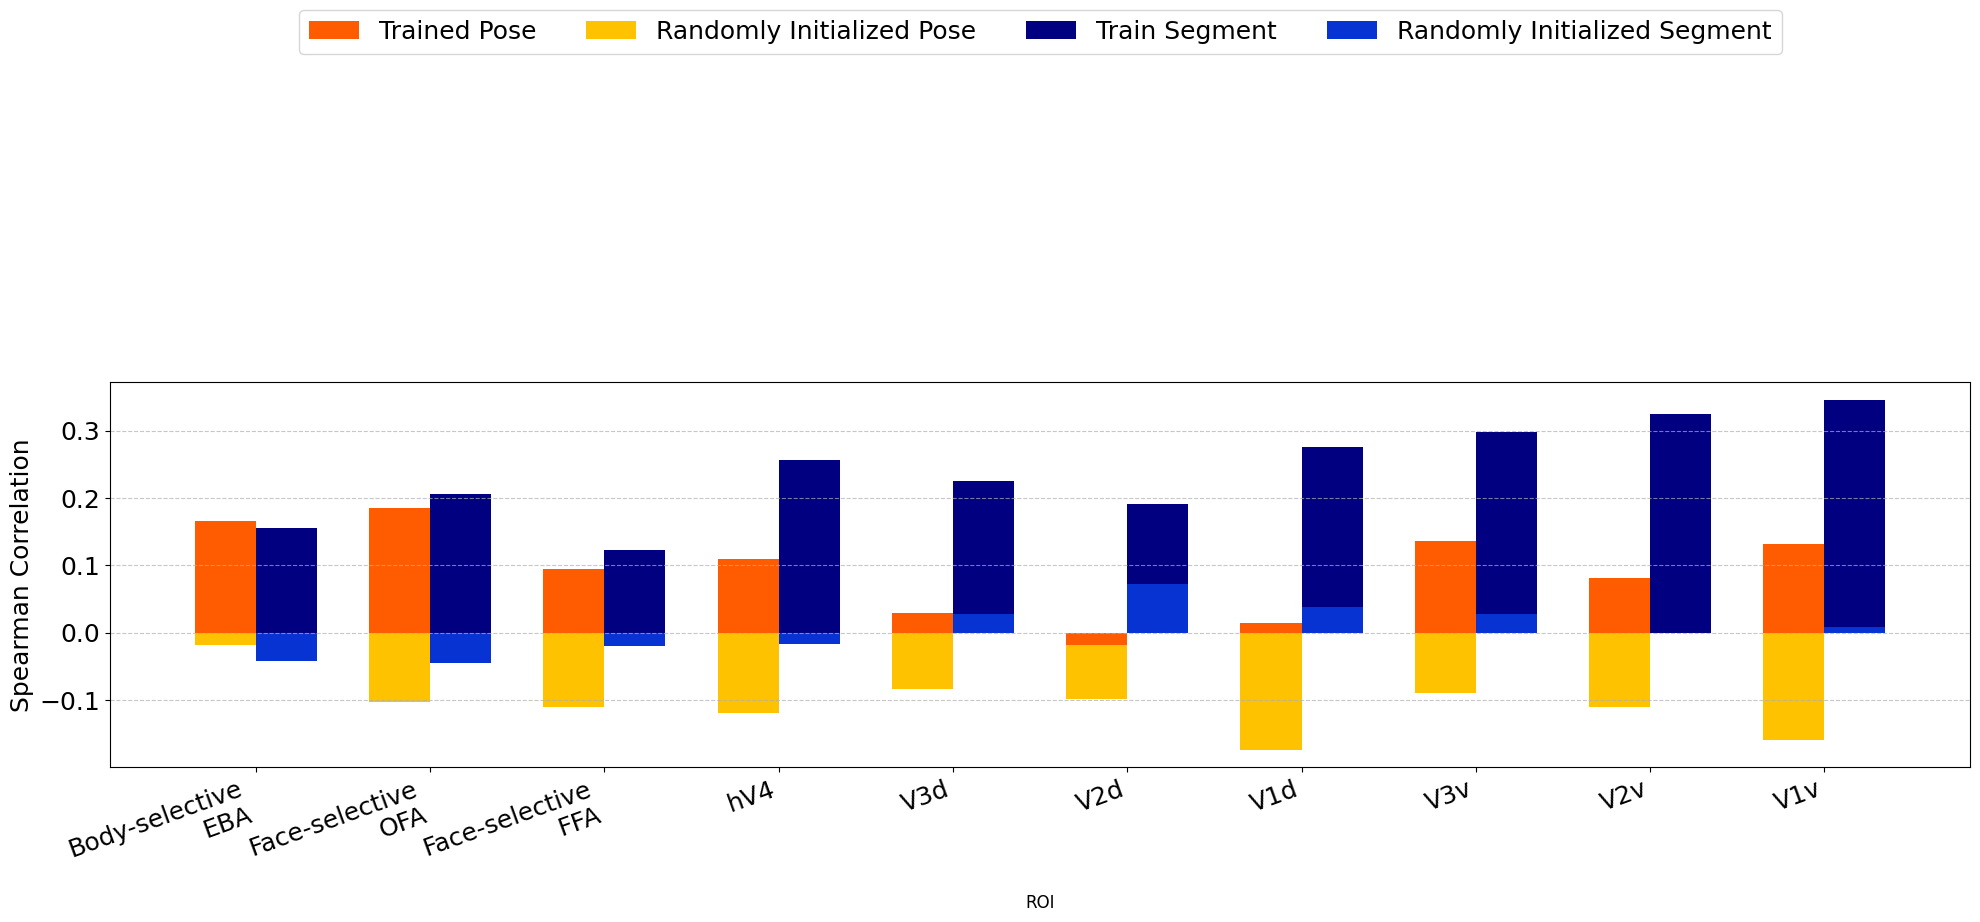

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def generate_roi_stacked_bar_chart_extended(merged_data):
    """
    Generate a stacked bar chart where each ROI has two bars:
    - One for (pose/random-pose)
    - One for (seg/random-seg)
    """

    full_roi_order = ['EBA', 'OFA', 'FFA_1', 'hV4', 'V3d', 'V2d', 'V1d', 'V3v', 'V2v',  'V1v',]
    # Sort based on the adjusted order
    merged_data['roi'] = pd.Categorical(merged_data['roi'], categories=full_roi_order, ordered=True)
    merged_data = merged_data.sort_values('roi')

    # Create the figure
    fig, ax = plt.subplots(figsize=(24, 5))

    # Get x positions
    x = np.arange(len(merged_data))
    width = 0.35  # Width of each bar

    # Ensure correct stacking even when values are negative
    pose_bottom = np.where(merged_data['spearman_mean_pose'] >= 0, 0, merged_data['spearman_mean_pose'])
    seg_bottom = np.where(merged_data['spearman_mean_seg'] >= 0, 0, merged_data['spearman_mean_seg'])

    cmap = create_enhanced_colormap()
    colors = cmap(np.linspace(0, 1, 8))  # Extract 4 distinct colors

    # Plot pose/random-pose stacked bars
    pose_bars = ax.bar(x - width/2, merged_data['spearman_mean_pose'], width, label='Trained Pose', color=colors[5])
    random_pose_bars = ax.bar(x - width/2, merged_data['spearman_mean_random_pose'], width,
                              bottom=pose_bottom, label='Randomly Initialized Pose', color=colors[6])

    # Plot seg/random-seg stacked bars
    seg_bars = ax.bar(x + width/2, merged_data['spearman_mean_seg'], width, label='Train Segment', color=colors[0])
    random_seg_bars = ax.bar(x + width/2, merged_data['spearman_mean_random_seg'], width,
                              bottom=seg_bottom, label='Randomly Initialized Segment', color=colors[1])

    # Add error bars safely
    def add_error_bars(ax, x_positions, means, errors):
        if errors is not None:
            ax.errorbar(x=x_positions, y=means, yerr=errors, fmt='none', ecolor='black', capsize=3)


    # Labels and title
    ax.set_xlabel('ROI', fontsize=12)
    ax.set_ylabel('Spearman Correlation', fontsize=18)

    # Set x-axis ticks and labels
    ax.set_xticks(x)

    labels = list(merged_data['roi'])  # Convert to a list
    labels[0] = "Body-selective\nEBA"  # Modify the first label safely
    labels[1] = "Face-selective\nOFA"  # Modify the first label safely
    labels[2] = "Face-selective\nFFA"  # Modify the first label safely

    ax.set_xticklabels(labels, rotation=20, ha='right', fontsize=18)
    ax.tick_params(axis='y', labelsize=18)  # Increase y-tick font size

    # Add legend
    # Add legend
    ax.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 2), fontsize=18)

    # Add grid lines
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Adjust layout
    plt.tight_layout()

    return fig, ax

generate_roi_stacked_bar_chart_extended(merged_data)

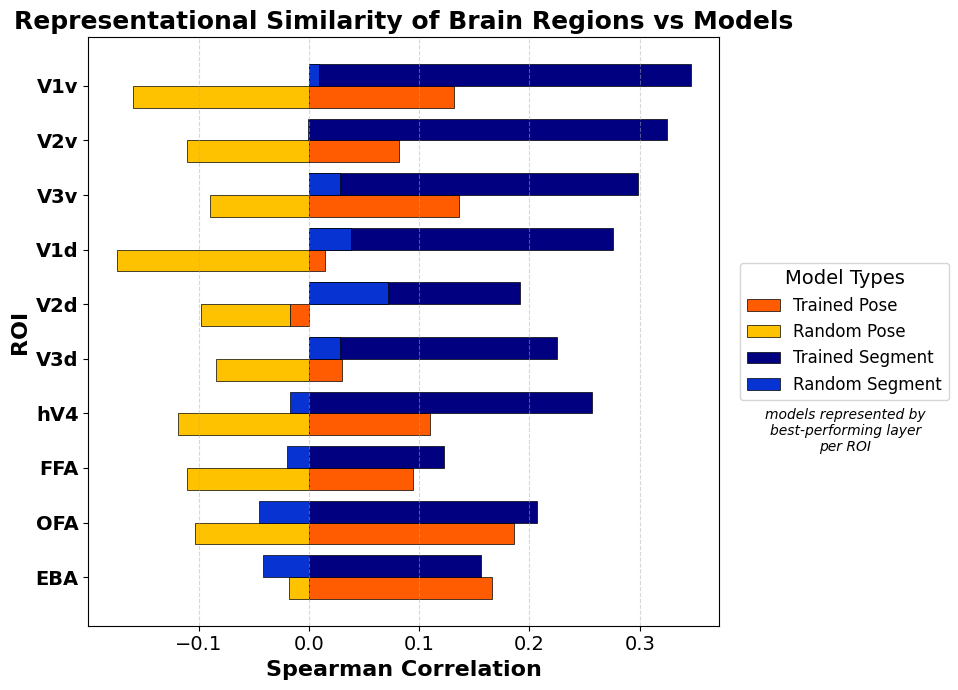

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def generate_roi_stacked_bar_chart_extended(merged_data):
    """
    Generate a taller vertical stacked bar chart for ROI correlations
    """
    full_roi_order = ['V1v', 'V2v','V3v', 'V1d', 'V2d',  'V3d', 'hV4', 'FFA_1', 'OFA', 'EBA']
    full_roi_order.reverse()
    # Sort based on the reversed order
    merged_data['roi'] = pd.Categorical(merged_data['roi'], categories=full_roi_order, ordered=True)
    merged_data = merged_data.sort_values('roi')

    # Create a taller figure
    fig, ax = plt.subplots(figsize=(11, 7), dpi=100)

    # Get y positions
    y = np.arange(len(merged_data))
    height = 0.4  # Increased bar height

    # Ensure correct stacking even when values are negative
    pose_bottom = np.where(merged_data['spearman_mean_pose'] >= 0, 0, merged_data['spearman_mean_pose'])
    seg_bottom = np.where(merged_data['spearman_mean_seg'] >= 0, 0, merged_data['spearman_mean_seg'])

    # Color palette
    cmap = create_enhanced_colormap()
    colors = cmap(np.linspace(0, 1, 8))  # Extract 4 distinct colors

    # Plot horizontal bars
    pose_bars = ax.barh(y - height/2, merged_data['spearman_mean_pose'], height,
                        label='Trained Pose', color=colors[5], edgecolor='black', linewidth=0.5)
    random_pose_bars = ax.barh(y - height/2, merged_data['spearman_mean_random_pose'], height,
                                left=pose_bottom, label='Random Pose', color=colors[6], edgecolor='black', linewidth=0.5)

    # Plot seg/random-seg horizontal bars
    seg_bars = ax.barh(y + height/2, merged_data['spearman_mean_seg'], height,
                       label='Trained Segment', color=colors[0], edgecolor='black', linewidth=0.5)
    random_seg_bars = ax.barh(y + height/2, merged_data['spearman_mean_random_seg'], height,
                               left=seg_bottom, label='Random Segment', color=colors[1], edgecolor='black', linewidth=0.5)

    # Labels and title with BOLD and LARGER text
    ax.set_ylabel('ROI', fontsize=16, fontweight='bold')
    ax.set_xlabel('Spearman Correlation', fontsize=16, fontweight='bold')

    # Set y-axis ticks and labels
    ax.set_yticks(y)
    labels = list(merged_data['roi'])

    # Modify labels for readability
    # labels[9] = "EBA"
    # labels[8] = "OFA"
    labels[2] = "FFA"

    ax.set_yticklabels(labels, fontsize=14, fontweight='bold')
    ax.tick_params(axis='x', labelsize=14)


    # Legend with BOLD and LARGER text
    legend = ax.legend(loc='center left',
                      bbox_to_anchor=(1.02, 0.5),
                      fontsize=12,
                      title='Model Types',
                      title_fontsize=14)

    # Add text below the legend
    ax.text(1.2, 0.37, 'models represented by\nbest-performing layer\nper ROI',
            transform=ax.transAxes, fontsize=10, style='italic', va='top', ha='center')

    # Grid lines
    ax.grid(axis='x', linestyle='--', alpha=0.5)

    # Title with BOLD and LARGER text
    plt.title('Representational Similarity of Brain Regions vs Models', fontsize=18, fontweight='bold')

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 0.9, 1])

    return fig, ax
fig, ax = generate_roi_stacked_bar_chart_extended(merged_data)
plt.show()

(<Figure size 1200x600 with 1 Axes>,
 <Axes: xlabel='ROI', ylabel='Spearman Correlation'>)

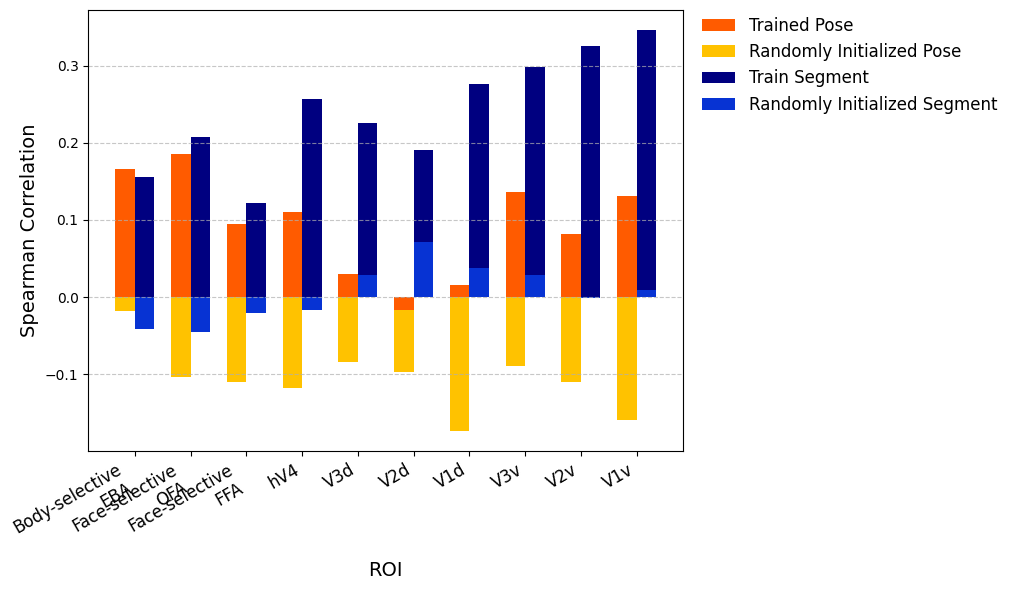

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def generate_roi_stacked_bar_chart_extended(merged_data):
    """
    Generate a stacked bar chart where each ROI has two bars:
    - One for (pose/random-pose)
    - One for (seg/random-seg)
    """

    full_roi_order = ['EBA', 'OFA', 'FFA_1', 'hV4', 'V3d', 'V2d', 'V1d', 'V3v', 'V2v', 'V1v']

    # Sort ROIs based on the adjusted order
    merged_data['roi'] = pd.Categorical(merged_data['roi'], categories=full_roi_order, ordered=True)
    merged_data = merged_data.sort_values('roi')

    # Create the figure
    fig, ax = plt.subplots(figsize=(12, 6))  # Adjusted size

    # Get x positions
    x = np.arange(len(merged_data))
    width = 0.35  # Width of each bar

    # Ensure correct stacking even when values are negative
    pose_bottom = np.where(merged_data['spearman_mean_pose'] >= 0, 0, merged_data['spearman_mean_pose'])
    seg_bottom = np.where(merged_data['spearman_mean_seg'] >= 0, 0, merged_data['spearman_mean_seg'])

    # Define colors
    cmap = create_enhanced_colormap()
    colors = cmap(np.linspace(0, 1, 8))  # Extract 4 distinct colors

    # Plot pose/random-pose stacked bars
    pose_bars = ax.bar(x - width/2, merged_data['spearman_mean_pose'], width, label='Trained Pose', color=colors[5])
    random_pose_bars = ax.bar(x - width/2, merged_data['spearman_mean_random_pose'], width,
                              bottom=pose_bottom, label='Randomly Initialized Pose', color=colors[6])

    # Plot seg/random-seg stacked bars
    seg_bars = ax.bar(x + width/2, merged_data['spearman_mean_seg'], width, label='Train Segment', color=colors[0])
    random_seg_bars = ax.bar(x + width/2, merged_data['spearman_mean_random_seg'], width,
                              bottom=seg_bottom, label='Randomly Initialized Segment', color=colors[1])

    # Labels and title
    ax.set_xlabel('ROI', fontsize=14)
    ax.set_ylabel('Spearman Correlation', fontsize=14)

    # Set x-axis ticks and labels
    ax.set_xticks(x)
    labels = list(merged_data['roi'])  # Convert to a list
    labels[0] = "Body-selective\nEBA"
    labels[1] = "Face-selective\nOFA"
    labels[2] = "Face-selective\nFFA"
    ax.set_xticklabels(labels, rotation=30, ha='right', fontsize=12)

    # Add vertical legend to the right
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=12, borderaxespad=0, frameon=False, ncol=1)

    # Add grid lines
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Ensure space for the vertical legend

    return fig, ax

# Example usage
generate_roi_stacked_bar_chart_extended(merged_data)


In [ ]:
full_seg = seg_stats.merge(random_seg_stats, on='roi', how='inner')

,subject_x,model_x,roi,laterality_x,layer_name_x,spearman_x,p_value_x,subject_y,model_y,laterality_y,layer_name_y,spearman_y,p_value_y
0,1,seg,EBA,concatenated,model.model.22.cv4.2.1.conv,0.155796,4.887042e-163,1,random_seg,concatenated,model.model.22.cv3.2.1.conv,-0.041137,9.070887e-13
1,1,seg,FFA_1,concatenated,model.model.22.cv3.1.1.conv,0.122398,6.372689e-101,1,random_seg,concatenated,model.model.22.proto.cv3.conv,-0.020219,4.478808e-04
2,1,seg,OFA,concatenated,model.model.22.cv3.1.1.conv,0.206891,1.252861e-288,1,random_seg,concatenated,model.model.22.proto.cv3.conv,-0.045133,4.556954e-15
3,1,seg,V1d,concatenated,model.model.22.cv3.1.1.conv,0.275475,0.000000e+00,1,random_seg,concatenated,model.model.22.proto.cv3.conv,0.037883,4.755804e-11
4,1,seg,V1v,concatenated,model.model.22.cv3.0.1.conv,0.345992,0.000000e+00,1,random_seg,concatenated,model.model.22.proto.cv3.conv,0.008768,1.280088e-01
5,1,seg,V2d,concatenated,model.model.22.cv3.0.1.conv,0.191143,6.921527e-246,1,random_seg,concatenated,model.model.22.proto.cv3.conv,0.071958,6.816610e-36
6,1,seg,V2v,concatenated,model.model.22.cv3.0.1.conv,0.324715,0.000000e+00,1,random_seg,concatenated,model.model.22.proto.cv3.conv,-0.000783,8.918507e-01
7,1,seg,V3d,concatenated,model.model.22.cv3.0.1.conv,0.224926,0.000000e+00,1,random_seg,concatenated,model.model.22.proto.cv3.conv,0.028519,7.362134e-07
8,1,seg,V3v,concatenated,model.model.22.cv3.1.1.conv,0.298622,0.000000e+00,1,random_seg,concatenated,model.model.22.proto.cv3.conv,0.028035,1.130061e-06
9,1,seg,hV4,concatenated,model.model.22.cv3.1.1.conv,0.257115,0.000000e+00,1,random_seg,concatenated,model.model.22.proto.cv3.conv,-0.017338,2.612943e-03


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


def generate_roi_stacked_bar_chart_extended(pose_stats, random_pose_stats, seg_stats, random_seg_stats):
    """
    Generate a stacked bar chart where each ROI has two bars:
    - One for (pose/random-pose)
    - One for (seg/random-seg)
    """

    # Print column names to debug
    print("pose_stats columns:", pose_stats.columns)
    print("random_pose_stats columns:", random_pose_stats.columns)
    print("seg_stats columns:", seg_stats.columns)
    print("random_seg_stats columns:", random_seg_stats.columns)

    # Rename columns for clarity before merging
    pose_stats = pose_stats.rename(columns={'spearman_mean': 'spearman_mean_pose', 'spearman_sem': 'spearman_sem_pose'})
    random_pose_stats = random_pose_stats.rename(columns={'spearman_mean': 'spearman_mean_random_pose', 'spearman_sem': 'spearman_sem_random_pose'})
    seg_stats = seg_stats.rename(columns={'spearman_mean': 'spearman_mean_seg', 'spearman_sem': 'spearman_sem_seg'})
    random_seg_stats = random_seg_stats.rename(columns={'spearman_mean': 'spearman_mean_random_seg', 'spearman_sem': 'spearman_sem_random_seg'})

    # Ensure there are no duplicate ROIs by averaging duplicates
    # def aggregate_data(df, mean_cols):
    #     return df.groupby('roi')[mean_cols].mean().reset_index()

    # Merge datasets
    merged_data = (
        pose_stats
        .merge(random_pose_stats, on='roi', how='inner')
        .merge(seg_stats, on='roi', how='inner')
        .merge(random_seg_stats, on='roi', how='inner')
    )

    # Hardcoded sorting order
    roi_order = ['EBA', 'OFA', 'hV4', 'v3v', 'v3d', 'v2v', 'v2d', 'v1v', 'v1d']
    merged_data['roi'] = pd.Categorical(merged_data['roi'], categories=roi_order, ordered=True)
    merged_data = merged_data.sort_values('roi')

    return merged_data

    # # Create the figure
    # fig, ax = plt.subplots(figsize=(14, 8))

    # # Get x positions
    # x = np.arange(len(merged_data))
    # width = 0.35  # Width of each bar

    # # Plot pose/random-pose stacked bars
    # pose_bars = ax.bar(x - width/2, merged_data['spearman_mean_pose'], width, label='Pose', color='steelblue')
    # random_pose_bars = ax.bar(x - width/2, merged_data['spearman_mean_random_pose'], width,
    #                           bottom=merged_data['spearman_mean_pose'], label='Random Pose', color='lightsteelblue')

    # # Plot seg/random-seg stacked bars
    # seg_bars = ax.bar(x + width/2, merged_data['spearman_mean_seg'], width, label='Seg', color='darkorange')
    # random_seg_bars = ax.bar(x + width/2, merged_data['spearman_mean_random_seg'], width,
    #                           bottom=merged_data['spearman_mean_seg'], label='Random Seg', color='moccasin')

    # # Add error bars
    # def add_error_bars(ax, x_positions, means, errors):
    #     ax.errorbar(x=x_positions, y=means, yerr=errors, fmt='none', ecolor='black', capsize=3)

    # add_error_bars(ax, x - width/2, merged_data['spearman_mean_pose'], merged_data['spearman_sem_pose'])
    # add_error_bars(ax, x - width/2, merged_data['spearman_mean_random_pose'], merged_data['spearman_sem_random_pose'])
    # add_error_bars(ax, x + width/2, merged_data['spearman_mean_seg'], merged_data['spearman_sem_seg'])
    # add_error_bars(ax, x + width/2, merged_data['spearman_mean_random_seg'], merged_data['spearman_sem_random_seg'])

    # # Labels and title
    # ax.set_xlabel('ROI', fontsize=12)
    # ax.set_ylabel('Spearman Correlation', fontsize=12)
    # ax.set_title('Pose vs Random Pose and Seg vs Random Seg Correlations Across ROIs', fontsize=14)

    # # Set x-axis ticks and labels
    # ax.set_xticks(x)
    # ax.set_xticklabels(merged_data['roi'], rotation=45, ha='right')

    # # Add legend
    # ax.legend()

    # # Add grid lines
    # ax.grid(axis='y', linestyle='--', alpha=0.7)

    # # Adjust layout
    # plt.tight_layout()

    # return fig, ax


data = generate_roi_stacked_bar_chart_extended(pose_stats[pose_stats['laterality'] == 'concatenated'], random_pose_stats[random_pose_stats['laterality'] == 'concatenated'], seg_stats[seg_stats['laterality'] == 'concatenated'], random_seg_stats[random_seg_stats['laterality'] == 'concatenated'])
data

pose_stats columns: Index(['roi', 'laterality', 'spearman_mean', 'spearman_std', 'spearman_count',
       'p_value_mean', 'spearman_sem', 'model', 'laterality_order',
       'roi_order'],
      dtype='object')
random_pose_stats columns: Index(['roi', 'laterality', 'spearman_mean', 'spearman_std', 'spearman_count',
       'p_value_mean', 'spearman_sem', 'model', 'laterality_order',
       'roi_order'],
      dtype='object')
seg_stats columns: Index(['roi', 'laterality', 'spearman_mean', 'spearman_std', 'spearman_count',
       'p_value_mean', 'spearman_sem', 'model', 'laterality_order',
       'roi_order'],
      dtype='object')
random_seg_stats columns: Index(['roi', 'laterality', 'spearman_mean', 'spearman_std', 'spearman_count',
       'p_value_mean', 'spearman_sem', 'model', 'laterality_order',
       'roi_order'],
      dtype='object')


MergeError: Passing 'suffixes' which cause duplicate columns {'laterality_x', 'laterality_order_x', 'roi_order_x', 'spearman_std_x', 'model_x', 'spearman_count_x', 'p_value_mean_x'} is not allowed.

In [ ]:
merged_data

NameError: name 'merged_data' is not defined

In [ ]:
print("pose_stats columns:", pose_stats.columns)
print("random_pose_stats columns:", random_pose_stats.columns)
print("seg_stats columns:", seg_stats.columns)
print("random_seg_stats columns:", random_seg_stats.columns)


pose_stats columns: Index(['roi', 'laterality', 'spearman_mean', 'spearman_std', 'spearman_count',
       'p_value_mean', 'spearman_sem', 'model', 'laterality_order',
       'roi_order'],
      dtype='object')
random_pose_stats columns: Index(['roi', 'laterality', 'spearman_mean', 'spearman_std', 'spearman_count',
       'p_value_mean', 'spearman_sem', 'model', 'laterality_order',
       'roi_order'],
      dtype='object')
seg_stats columns: Index(['roi', 'laterality', 'spearman_mean', 'spearman_std', 'spearman_count',
       'p_value_mean', 'spearman_sem', 'model', 'laterality_order',
       'roi_order'],
      dtype='object')
random_seg_stats columns: Index(['roi', 'laterality', 'spearman_mean', 'spearman_std', 'spearman_count',
       'p_value_mean', 'spearman_sem', 'model', 'laterality_order',
       'roi_order'],
      dtype='object')


In [ ]:
# Merge data to align ROIs
merged_df = pose_stats.merge(random_pose_stats, on='roi', suffixes=('_pose', '_random_pose'))

# Sort by pose correlation for better visualization
merged_df = merged_df.sort_values(by='spearman_mean', ascending=False)

# Extract values for plotting
ROIs = merged_df['roi']
pose_values = merged_df['spearman_mean']
random_pose_values = merged_df['Spearman_random_pose']

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(ROIs, pose_values, label='Pose', color='blue')
ax.bar(ROIs, random_pose_values, bottom=pose_values, label='Random Pose', color='red')

# Labels and legend
ax.set_ylabel('Spearman Correlation')
ax.set_xlabel('ROI')
ax.set_title('Spearman Correlation for Pose and Random Pose Across ROIs')
ax.legend()
plt.xticks(rotation=45)
plt.show()


KeyError: 'Spearman_pose'

In [ ]:
seg_stats[seg_stats['laterality'] == 'concatenated']

,roi,laterality,spearman_mean,spearman_std,spearman_count,p_value_mean,spearman_sem,model,laterality_order,roi_order
12,V1v,concatenated,0.345992,NaN,1,0.000000e+00,NaN,seg,0,0
18,V2v,concatenated,0.324715,NaN,1,0.000000e+00,NaN,seg,0,1
24,V3v,concatenated,0.298622,NaN,1,0.000000e+00,NaN,seg,0,2
9,V1d,concatenated,0.275475,NaN,1,0.000000e+00,NaN,seg,0,3
27,hV4,concatenated,0.257115,NaN,1,0.000000e+00,NaN,seg,0,4
21,V3d,concatenated,0.224926,NaN,1,0.000000e+00,NaN,seg,0,5
6,OFA,concatenated,0.206891,NaN,1,1.252861e-288,NaN,seg,0,6
15,V2d,concatenated,0.191143,NaN,1,6.921527e-246,NaN,seg,0,7
0,EBA,concatenated,0.155796,NaN,1,4.887042e-163,NaN,seg,0,8
3,FFA_1,concatenated,0.122398,NaN,1,6.372689e-101,NaN,seg,0,9


In [ ]:
random_seg_stats[random_seg_stats['laterality'] == 'concatenated']

,roi,laterality,spearman_mean,spearman_std,spearman_count,p_value_mean,spearman_sem,model,laterality_order,roi_order
15,V2d,concatenated,0.071958,NaN,1,6.816610e-36,NaN,random_seg,0,0
9,V1d,concatenated,0.037883,NaN,1,4.755804e-11,NaN,random_seg,0,1
21,V3d,concatenated,0.028519,NaN,1,7.362134e-07,NaN,random_seg,0,2
24,V3v,concatenated,0.028035,NaN,1,1.130061e-06,NaN,random_seg,0,3
12,V1v,concatenated,0.008768,NaN,1,1.280088e-01,NaN,random_seg,0,4
18,V2v,concatenated,-0.000783,NaN,1,8.918507e-01,NaN,random_seg,0,5
27,hV4,concatenated,-0.017338,NaN,1,2.612943e-03,NaN,random_seg,0,6
3,FFA_1,concatenated,-0.020219,NaN,1,4.478808e-04,NaN,random_seg,0,7
0,EBA,concatenated,-0.041137,NaN,1,9.070887e-13,NaN,random_seg,0,8
6,OFA,concatenated,-0.045133,NaN,1,4.556954e-15,NaN,random_seg,0,9


In [ ]:
import pandas as pd

# Define the file name
file_name = "stats_final.xlsx"

# Create an Excel writer object
with pd.ExcelWriter(file_name) as writer:
    pose_stats.to_excel(writer, sheet_name="Pose Stats", index=False)
    seg_stats.to_excel(writer, sheet_name="Seg Stats", index=False)
    random_pose_stats.to_excel(writer, sheet_name="Random Pose Stats", index=False)
    random_seg_stats.to_excel(writer, sheet_name="Random Seg Stats", index=False)

print(f"Saved as {file_name}")


Saved as stats_final.xlsx


In [ ]:
valid_results_df

,subject,model,roi,laterality,layer_name,spearman,p_value
0,1,pose,EBA,concatenated,model.model.22.cv4.2.1.conv,0.166434,4.288848e-186
1,1,pose,EBA,left,model.model.22.cv4.2.1.conv,0.132460,5.174794e-118
2,1,pose,EBA,right,model.model.22.cv4.2.1.conv,0.140724,4.317237e-133
3,1,pose,FFA_1,concatenated,model.model.22.cv4.2.1.conv,0.094789,4.241668e-61
4,1,pose,FFA_1,left,model.model.22.cv4.2.1.conv,0.053071,2.999804e-20
...,...,...,...,...,...,...,...
955,8,seg,V3v,left,model.model.22.cv3.0.1.conv,0.113613,1.148617e-81
956,8,seg,V3v,right,model.model.22.cv3.2.1.conv,0.136873,5.336533e-118
957,8,seg,hV4,concatenated,model.model.22.cv3.1.1.conv,0.108604,9.577700e-75
958,8,seg,hV4,left,model.model.22.cv3.1.1.conv,0.102909,2.919868e-67


# Save best RDMs to be converted to Excel in separate notebook https://colab.research.google.com/drive/1AvKPzfsR5fWxTnszyoYIQRbptjAwJs3a?authuser=1#scrollTo=utgHiHNA5uKW

In [ ]:
best_performing_layers = list(zip(valid_results_df['subject'], valid_results_df['model'], valid_results_df['roi'], valid_results_df['laterality'], valid_results_df['layer_name']))

In [ ]:
def create_nested_dictionary(best_performing_layers, rdm_neural_networks):
    # Initialize the main dictionary with subjects first (as integers)
    result = {}
    for subject in range(1, 9):
        # Initialize the dictionary for each subject
        result[str(subject)] = {
            'pose': {'train': {}, 'val': {}},
            'seg': {'train': {}, 'val': {}},
            'random_pose': {'train': {}, 'val': {}},
            'random_seg': {'train': {}, 'val': {}}
        }

    for subject, task, roi, laterality, layer in best_performing_layers:
        subject_str = str(subject)

        # Ensure the necessary dictionaries exist for each subject, task, and laterality
        if roi not in result[subject_str][task]['train']:
            result[subject_str][task]['train'][roi] = {'concatenated': None, 'left': None, 'right': None}
        if roi not in result[subject_str][task]['val']:
            result[subject_str][task]['val'][roi] = {'concatenated': None, 'left': None, 'right': None}

        # Access RDMs for both train and val from the neural network dictionary
        train_rdm = rdm_neural_networks['train'][subject][task][layer]
        val_rdm = rdm_neural_networks['val'][subject][task][layer]

        rdms_of_features_train = tuple(rdm_image_features['train'][subject][key] for key in image_feature_list)
        rdms_of_features_val = tuple(rdm_image_features['val'][subject][key] for key in image_feature_list)

        # Store the RDMs in the result dictionary
        result[subject_str][task]['train'][roi][laterality] = RDMPreprocessor.remove_influence(train_rdm, *rdms_of_features_train)
        result[subject_str][task]['val'][roi][laterality] = RDMPreprocessor.remove_influence(val_rdm, *rdms_of_features_val)

    return result

# Example usage:
nested_dict = create_nested_dictionary(best_performing_layers, rdm_neural_networks)

import pickle

# Save the nested dictionary to a file
with open('/content/drive/MyDrive/ML Project/RDM_results/best_rdms_final.pkl', 'wb') as f:
    pickle.dump(nested_dict, f)


In [ ]:
nested_dict['1']['pose']['val']['EBA']['concatenated']

KeyError: 'valid'

In [ ]:
nested_dict['1']['seg']['train']['EBA']['concatenated']

array([ 0.03413955, -0.08375893, -0.02081812, ..., -0.00697918,
        0.10037585,  0.04293963])

In [ ]:
seg_model

array([-0.06076115, -0.05397742, -0.05000195, ..., -0.11397928,
       -0.02635998,  0.05054871])

In [ ]:
pose_model

array([ 0.05572088,  0.0591374 ,  0.04707994, ..., -0.14503724,
        0.0313693 ,  0.04000935])

In [ ]:
with open("/content/drive/MyDrive/ML Project/seg_model.pkl", "rb") as f:
    seg_model = pickle.load(f)

with open("/content/drive/MyDrive/ML Project/pose_model.pkl", "rb") as f:
    pose_model = pickle.load(f)

# Visualize results


## Some visualization functions

In [ ]:
# Function to plot the correlation per ROI and Laterality
def plot_correlation(results_df, model_type):
    # Initialize plot
    plt.figure(figsize=(10, 6))

    # Assign colors for all ROIs
    colors = ['blue', 'green', 'orange', 'purple', 'red', 'cyan']  # Add more colors if needed
    roi_color_map = {}

    # Filter results for the selected model type
    filtered_results = {}
    for _, row in results_df.iterrows():
        if row['model'] != model_type:
            continue  # Skip rows that are not of the selected model type

        roi = row['roi']
        laterality = row['laterality']
        layer = row['layer_num']  # Use numerical layer index
        spearman_corr = row['spearman']

        if roi not in filtered_results:
            filtered_results[roi] = {'left': [], 'right': []}

        # Store all correlations (positive and negative) for laterality (left or right)
        filtered_results[roi][laterality].append((layer, spearman_corr))

    # Create scatter plots for each ROI, left and right laterality
    for roi, laterality_data in filtered_results.items():
        for laterality, data in laterality_data.items():
            # Assign a unique color for each ROI
            if roi not in roi_color_map:
                roi_color_map[roi] = colors.pop(0)

            # Extract layers and correlations
            layers = [x[0] for x in data]
            correlations = [x[1] for x in data]

            # Use different markers for left (dot) and right (cross)
            marker = 'o' if laterality == 'left' else 'x'

            # Plot the data
            plt.scatter(layers, correlations, label=f'{roi} - {laterality}', color=roi_color_map[roi], marker=marker)

    # Set plot labels and title
    plt.xlabel('Layer Number/Network Depth')
    plt.ylabel('Spearman Correlation')
    plt.title(f'Spearman Correlation over Network Depth per ROI ({model_type.capitalize()})')

    # Set the x-axis limit based on the number of layers in the model
    num_layers = results_df['layer_num'].max() + 1  # Total number of layers (0 to num_layers)
    plt.xlim(0, num_layers)  # Set x-axis from 0 to the number of layers

    # Customize the legend to avoid duplicates
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1, 1))

    # Display plot
    plt.tight_layout()
    plt.show()

def plot_validated_results(df):
    # Extract unique subjects and models
    subjects = df['subject'].unique()
    models = df['model'].unique()

    fig, axes = plt.subplots(1, len(models), figsize=(12, 6), sharey=True)

    if len(models) == 1:
        axes = [axes]  # Ensure axes is iterable for a single model

    bar_width = 0.4  # Width of bars to keep them side by side

    for ax, model in zip(axes, models):
        # Filter the dataframe for the current model
        model_data = df[df['model'] == model]
        rois = model_data['roi'].unique()

        # Get the left and right spearman values for each ROI
        left_spearmans = []
        right_spearmans = []

        for roi in rois:
            roi_data = model_data[model_data['roi'] == roi]
            left_spearman = roi_data[roi_data['laterality'] == 'left']['spearman'].values[0]
            right_spearman = roi_data[roi_data['laterality'] == 'right']['spearman'].values[0]

            left_spearmans.append(left_spearman)
            right_spearmans.append(right_spearman)

        # Sort ROIs based on the maximum of left and right Spearman correlation (descending order)
        sorted_indices = np.argsort([max(left, right) for left, right in zip(left_spearmans, right_spearmans)])[::-1]
        rois_sorted = [rois[i] for i in sorted_indices]
        left_spearmans_sorted = [left_spearmans[i] for i in sorted_indices]
        right_spearmans_sorted = [right_spearmans[i] for i in sorted_indices]

        # Plot the bars for sorted ROIs
        y_positions_sorted = np.arange(len(rois_sorted))

        bars_left = ax.barh(y_positions_sorted - bar_width / 2, left_spearmans_sorted, bar_width, color='blue', label='Left')
        bars_right = ax.barh(y_positions_sorted + bar_width / 2, right_spearmans_sorted, bar_width, color='red', label='Right')

        # Display values on top of each bar
        for bar in bars_left:
            ax.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height() / 2,
                    f"{bar.get_width():.2f}", va='center', fontsize=10, color='blue')

        for bar in bars_right:
            ax.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height() / 2,
                    f"{bar.get_width():.2f}", va='center', fontsize=10, color='red')

        ax.set_yticks(y_positions_sorted)
        ax.set_yticklabels(rois_sorted)
        ax.set_xlim(0, 1.0)  # Set x-axis max to 1.0
        ax.set_xlabel("Spearman Correlation")
        ax.set_title(model)
        ax.legend(loc='lower right')  # Right for red, left for blue

    # Add a super title to the entire figure
    plt.suptitle('RSA (best explaining layer) on validation set', fontsize=16)

    # Truncate y-axis if necessary
    plt.ylim(-0.5, len(rois_sorted) - 0.5)

    plt.tight_layout()
    plt.show()

# Set the default font sizes
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

## Plot how spearman correlation changes with network depth

In [ ]:
plot_correlation(results_df, 'pose')
plot_correlation(results_df, 'seg')

## Plot RSA results of best-explaining RDM layer and ROI RDM on validation set

In [ ]:
# Function to plot the correlation per ROI and Laterality
def plot_correlation(results_df, model_type):
    # Initialize plot
    plt.figure(figsize=(10, 6))

    # Assign colors for all ROIs
    colors = ['blue', 'green', 'orange', 'purple', 'red', 'cyan']  # Add more colors if needed
    roi_color_map = {}

    # Filter results for the selected model type
    filtered_results = {}
    for _, row in results_df.iterrows():
        if row['model'] != model_type:
            continue  # Skip rows that are not of the selected model type

        roi = row['roi']
        laterality = row['laterality']
        layer = row['layer_num']  # Use numerical layer index
        spearman_corr = row['spearman']

        if roi not in filtered_results:
            filtered_results[roi] = {'left': [], 'right': []}

        # Store all correlations (positive and negative) for laterality (left or right)
        filtered_results[roi][laterality].append((layer, spearman_corr))

    # Create scatter plots for each ROI, left and right laterality
    for roi, laterality_data in filtered_results.items():
        for laterality, data in laterality_data.items():
            # Assign a unique color for each ROI
            if roi not in roi_color_map:
                roi_color_map[roi] = colors.pop(0)

            # Extract layers and correlations
            layers = [x[0] for x in data]
            correlations = [x[1] for x in data]

            # Use different markers for left (dot) and right (cross)
            marker = 'o' if laterality == 'left' else 'x'

            # Plot the data
            plt.scatter(layers, correlations, label=f'{roi} - {laterality}', color=roi_color_map[roi], marker=marker)

    # Set plot labels and title
    plt.xlabel('Layer Number/Network Depth')
    plt.ylabel('Spearman Correlation')
    plt.title(f'Spearman Correlation over Network Depth per ROI ({model_type.capitalize()})')

    # Set the x-axis limit based on the number of layers in the model
    num_layers = results_df['layer_num'].max() + 1  # Total number of layers (0 to num_layers)
    plt.xlim(0, num_layers)  # Set x-axis from 0 to the number of layers

    # Customize the legend to avoid duplicates
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1, 1))

    # Display plot
    plt.tight_layout()
    plt.show()

def plot_validated_results(df):
    # Extract unique subjects and models
    subjects = df['subject'].unique()
    models = df['model'].unique()

    fig, axes = plt.subplots(1, len(models), figsize=(12, 6), sharey=True)

    if len(models) == 1:
        axes = [axes]  # Ensure axes is iterable for a single model

    bar_width = 0.4  # Width of bars to keep them side by side

    for ax, model in zip(axes, models):
        # Filter the dataframe for the current model
        model_data = df[df['model'] == model]
        rois = model_data['roi'].unique()
        y_positions = np.arange(len(rois))

        # Get the left and right spearman values for each ROI
        left_spearmans = []
        right_spearmans = []

        for roi in rois:
            roi_data = model_data[model_data['roi'] == roi]
            left_spearman = roi_data[roi_data['laterality'] == 'left']['spearman'].values[0]
            right_spearman = roi_data[roi_data['laterality'] == 'right']['spearman'].values[0]

            left_spearmans.append(left_spearman)
            right_spearmans.append(right_spearman)

        # Plot the bars
        bars_left = ax.barh(y_positions - bar_width / 2, left_spearmans, bar_width, color='blue', label='Left')
        bars_right = ax.barh(y_positions + bar_width / 2, right_spearmans, bar_width, color='red', label='Right')

        # Display values on top of each bar
        for bar in bars_left:
            ax.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height() / 2,
                    f"{bar.get_width():.2f}", va='center', fontsize=10, color='blue')

        for bar in bars_right:
            ax.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height() / 2,
                    f"{bar.get_width():.2f}", va='center', fontsize=10, color='red')

        ax.set_yticks(y_positions)
        ax.set_yticklabels(rois)
        ax.set_xlim(0, 1.0)  # Set x-axis max to 1.0
        ax.set_xlabel("Spearman Correlation")
        ax.set_title(model)
        ax.legend(loc='lower right')  # Right for red, left for blue

    # Add a super title to the entire figure
    plt.suptitle('RSA (best explaining layer) on validation set', fontsize=16)

    plt.tight_layout()
    plt.show()

  # Set the default font sizes
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_validated_results(df):
    # Extract unique subjects and models
    subjects = df['subject'].unique()
    models = df['model'].unique()

    fig, axes = plt.subplots(1, len(models), figsize=(12, 6), sharey=True)

    if len(models) == 1:
        axes = [axes]  # Ensure axes is iterable for a single model

    bar_width = 0.4  # Width of bars to keep them side by side

    for ax, model in zip(axes, models):
        # Filter the dataframe for the current model
        model_data = df[df['model'] == 'seg']
        rois = model_data['roi'].unique()

        # Get the left and right spearman values for each ROI
        left_spearmans = []
        right_spearmans = []

        for roi in rois:
            roi_data = model_data[model_data['roi'] == roi]
            left_spearman = roi_data[roi_data['laterality'] == 'left']['spearman'].values[0]
            right_spearman = roi_data[roi_data['laterality'] == 'right']['spearman'].values[0]

            left_spearmans.append(left_spearman)
            right_spearmans.append(right_spearman)

        # Sort ROIs based on the maximum of left and right Spearman correlation (descending order)
        sorted_indices = np.argsort([max(left, right) for left, right in zip(left_spearmans, right_spearmans)])[::-1]
        rois_sorted = [rois[i] for i in sorted_indices]
        print(rois_sorted)
        left_spearmans_sorted = [left_spearmans[i] for i in sorted_indices]
        right_spearmans_sorted = [right_spearmans[i] for i in sorted_indices]

        # Reverse the y-tick labels to display them from top to bottom in reverse order
        y_positions_sorted = np.arange(len(rois_sorted))

        # Reverse the order of the bars and positions
        y_positions_reverse = y_positions_sorted[::-1]

        # Plot the bars in reversed order
        bars_left = ax.barh(y_positions_reverse - bar_width / 2, left_spearmans_sorted, bar_width, color='blue', label='Left')
        bars_right = ax.barh(y_positions_reverse + bar_width / 2, right_spearmans_sorted, bar_width, color='red', label='Right')

        # Display values on top of each bar
        for bar in bars_left:
            ax.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height() / 2,
                    f"{bar.get_width():.2f}", va='center', fontsize=10, color='blue')

        for bar in bars_right:
            ax.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height() / 2,
                    f"{bar.get_width():.2f}", va='center', fontsize=10, color='red')

        # Reverse the labels as well to match the reversed bars
        ax.set_yticks(y_positions_reverse)  # Update the tick positions
        ax.set_yticklabels(rois_sorted[::-1])  # Reverse the ROI labels to match the reversed bars

        ax.set_xlim(0, 1.0)  # Set x-axis max to 1.0
        ax.set_xlabel("Spearman Correlation")
        ax.set_title(model)
        ax.legend(loc='lower right')  # Right for red, left for blue

    # Add a super title to the entire figure
    plt.suptitle('RSA (best explaining layer) on validation set', fontsize=16)

    # Truncate y-axis if necessary
    plt.ylim(-0.5, len(rois_sorted) - 0.5)

    plt.tight_layout()
    plt.show()

# Set the default font sizes
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14


In [ ]:
        ax.set_yticks([3, 4, 9, 6, 5, 7, 10, 2, 1, 0, 8])


In [ ]:
plot_validated_results(valid_results_df)

In [ ]:
valid_results_df[(valid_results_df['model'] == 'pose')]


# Useful code below

# Construct RDMs from Lior's Responses

In [ ]:
### ALREADY CONSTRUCTED RDMs for subj1: EBA, FBA-1, v1v, v1d
##Uncomment if there are more subjects/ROIsalready
import os
import pandas as pd
import numpy as np

root = '/content/drive/MyDrive/ML Project/Subjects Results Lior/Subjects Results Lior/codes 25.1 & Subject 1'
rdm_results_path = '/content/drive/MyDrive/ML Project/RDM_results/subj1'

# Get list of Excel files
excel_files = [file for file in os.listdir(root) if file.endswith('.xlsx')]

# Separate files into left and right based on prefix
left_files = [file for file in excel_files if file.lower().startswith('l')]
right_files = [file for file in excel_files if file.lower().startswith('r')]

# Function to compute RDM from data matrix
def compute_rdm(data_matrix):
    # Placeholder function - implement your actual RDM computation here
    return 1-np.corrcoef(data_matrix)

# Process each left file
for file in left_files:
    rdms_file_name = file.split('.')[0][1:] + "_rdms.npz"  # Remove 'l' and add .npz

    # Construct corresponding right file name
    right_file = file.replace('l', 'r', 1)

    # Check if both left and right files exist
    if os.path.isfile(f'{root}/{file}') and os.path.isfile(f'{root}/{right_file}'):
        # Read left and right responses
        left_responses = pd.read_excel(f'{root}/{file}')
        right_responses = pd.read_excel(f'{root}/{right_file}')

        # Extract numeric data and compute RDM for left and right responses
        rdms = {}
        for side, responses in [('left', left_responses), ('right', right_responses)]:
            numeric_data = responses.select_dtypes(include=[np.number])
            data_matrix = numeric_data.values.T  # Transpose to get variables as columns
            rdms[side] = compute_rdm(data_matrix)

        # Check if the file already exists and add a version number if needed
        save_path = f'{rdm_results_path}/{rdms_file_name}'
        if os.path.isfile(save_path):
            # Add versioning if the file exists
            version = 1
            while os.path.isfile(save_path):
                version += 1
                save_path = f'{rdm_results_path}/{file.split(".")[0][1:]}_v{version}_rdms.npz'

        # Save RDMs as npz file
        np.savez(save_path, **rdms)

        print(f"Processed {file} and {right_file}. Saved to {save_path}")
    else:
        print(f"Files {file} or {right_file} do not exist.")


In [ ]:
subject_ids[1]

In [ ]:
rdm_b

In [ ]:
import pandas as pd
import numpy as np
import os


# Define the base directory
base_dir = "/content/drive/MyDrive/ML Project/brain_results"

# Iterate through the dictionary and save each NumPy array as an Excel file
for train_val, subjects in rdm_brain_rois.items():  # 'train' or 'val'
    for subject_num, rois in subjects.items():  # subject number (1, 2, etc.)
        for roi, laterality_dict in rois.items():  # 'EBA', 'PPA', etc.
            for laterality, array in laterality_dict.items():  # 'left' or 'right'

                # Construct the save path
                save_dir = os.path.join(base_dir, f"subject_{subject_num}", train_val, roi)
                os.makedirs(save_dir, exist_ok=True)  # Create directories if they don't exist

                save_path = os.path.join(save_dir, f"{roi}_{laterality}_data.xlsx")

                # Convert array to DataFrame
                df = pd.DataFrame(array, columns=[f"{roi}_{laterality}"])

                # Save DataFrame to Excel
                with pd.ExcelWriter(save_path, engine='openpyxl') as writer:
                    df.to_excel(writer, sheet_name=f"{roi}_{laterality}", index=False, header=False)

                print(f"Saved: {save_path}")


In [ ]:
# with open("/content/drive/MyDrive/ML Project/seg_model.pkl", "wb") as f:
#   rdms_of_features = tuple(rdm_image_features['val'][1][key] for key in image_feature_list)
#   rdm_layer = rdm_neural_networks['val'][1]['seg']['model.model.22.cv4.2.1.conv']
#   rdm_layer_clean = RDMPreprocessor.remove_influence(rdm_layer, *rdms_of_features)
#   pickle.dump(rdm_layer_clean, f)

# print("File saved successfully.")
# with open("/content/drive/MyDrive/ML Project/pose_model.pkl", "wb") as f:
#   rdms_of_features = tuple(rdm_image_features['val'][1][key] for key in image_feature_list)
#   rdm_layer = rdm_neural_networks['val'][1]['pose']['model.model.22.cv4.2.1.conv']
#   rdm_layer_clean = RDMPreprocessor.remove_influence(rdm_layer, *rdms_of_features)
#   pickle.dump(rdm_layer_clean, f)

# print("File saved successfully.")

File saved successfully.


In [ ]:
with open("/content/drive/MyDrive/ML Project/pose_model.pkl", "rb") as f:
  data = pickle.load(f)

In [ ]:
data

array([ 0.05572088,  0.0591374 ,  0.04707994, ..., -0.14503724,
        0.0313693 ,  0.04000935])

In [ ]:
rdms_of_features = tuple(rdm_image_features['val'][1][key] for key in image_feature_list)
rdm_layer = rdm_neural_networks['val'][1]['pose']['model.model.22.cv4.2.1.conv']
rdm_layer_clean = RDMPreprocessor.remove_influence(rdm_layer, *rdms_of_features)

In [ ]:
rdm_layer_clean

array([ 0.05572088,  0.0591374 ,  0.04707994, ..., -0.14503724,
        0.0313693 ,  0.04000935])